In [15]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2
import albumentations as A
import lanms
import random
from albumentations.pytorch import ToTensorV2
from imageio import imread
from dataset import SceneTextDataset

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [16]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)

def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)

In [17]:
data_dir = '/opt/ml/input/data/ICDAR17_Korean'  ## datasets path
image_size = 1024
input_size = 512
dataset = SceneTextDataset(data_dir, split='train', image_size=image_size, crop_size=input_size,color_jitter=True,normalize=False)

with open(osp.join(data_dir, 'ufo/{}.json'.format('train')), 'r') as f:
    anno = json.load(f)
    
image_fnames = sorted(anno['images'].keys())


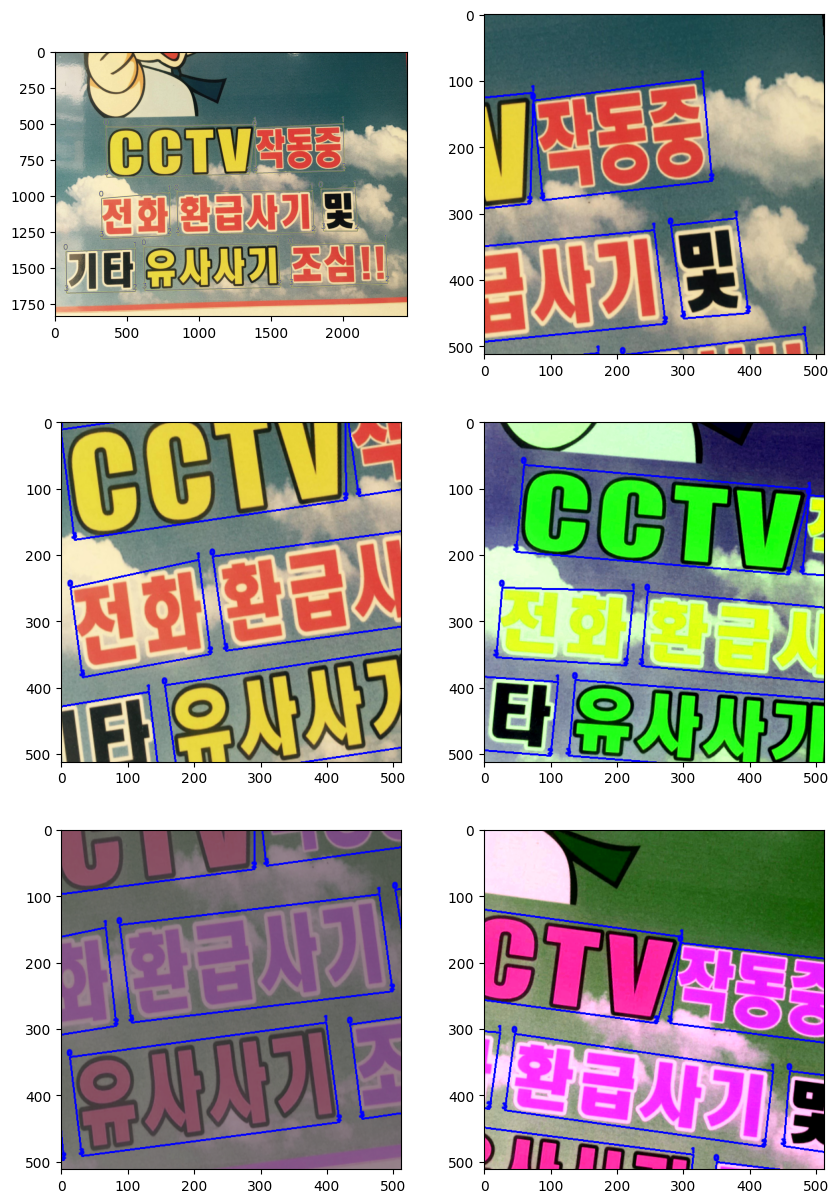

In [ ]:
idx = 42
image_fname = image_fnames[idx]
origin_img = plt.imread(os.path.join(data_dir, 'images', image_fname))
anno_keys = anno['images'][image_fname]['words'].keys()
bboxes = []
for k in anno_keys:
    bboxes.append(anno['images'][image_fname]['words'][k]['points'])

plt.figure(figsize=(10, 15))
img = origin_img.copy()
draw_bboxes(img, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)
plt.subplot(3, 2, 1)

plt.imshow(img)
for i in range(5):
    plt.subplot(3, 2, 2+i)
    input_img, word_bboxes, roi_mask = dataset[idx]
    draw_bboxes(input_img, word_bboxes, double_lined=False, thickness=2, thickness_sub=5, write_point_numbers=True)
    plt.imshow(input_img)
plt.show()